In [12]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import lib
np.random.seed(666)

In [13]:
rootfolder = '..'

Load the image and rescale it in $[0,1]$

In [14]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12

In [15]:
p2 = p // 2
p, p2

(7, 3)

Corrupt the image with white gaussian noise

In [16]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(0, sigma_noise, imsz)

Compute the psnr of the noisy input

In [17]:
psnr_noisy = lib.psnr(img, noisy_img)

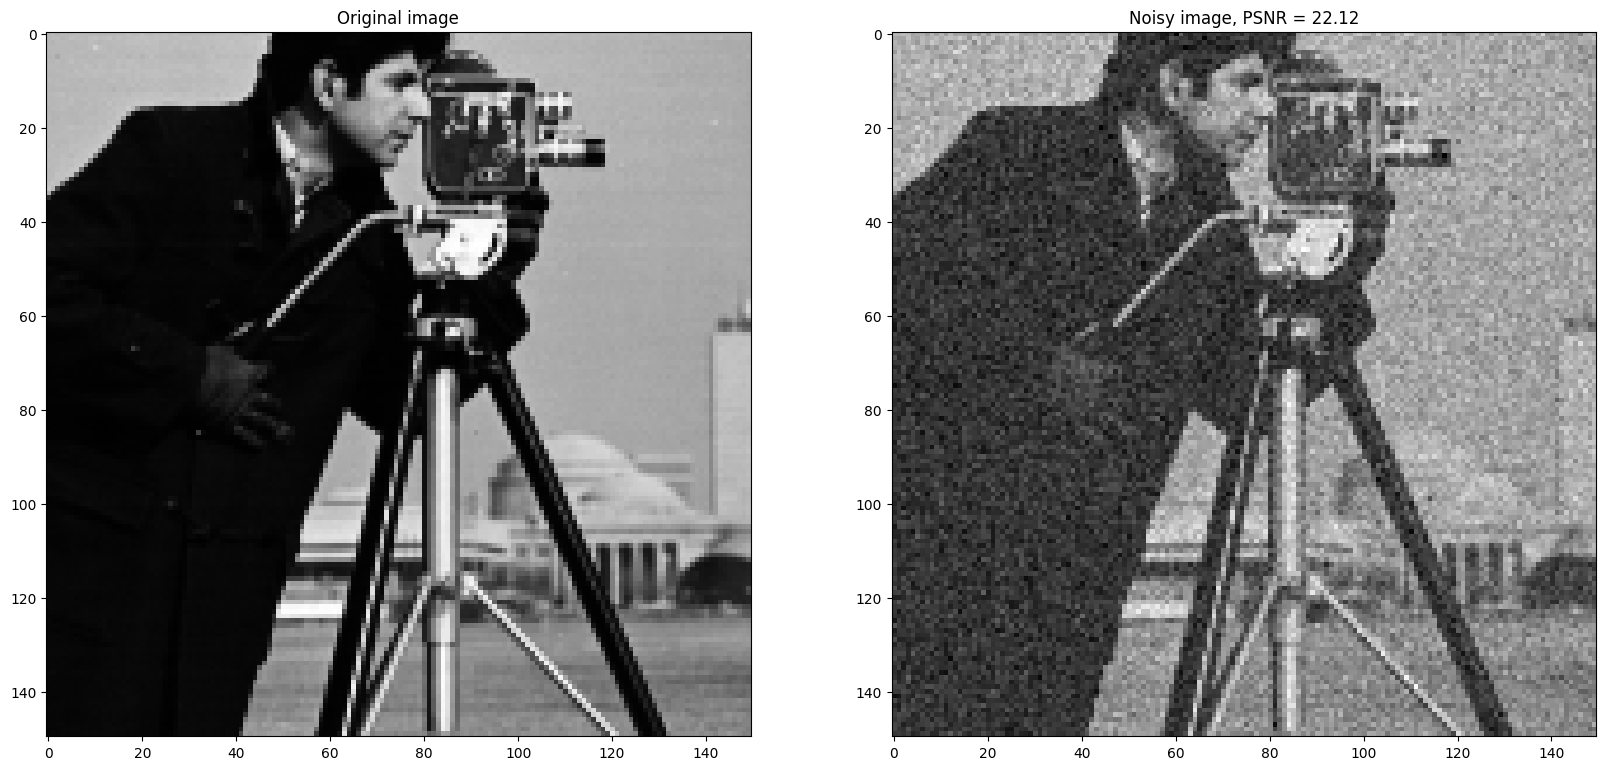

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}');

Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [19]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, p // 2, mode='symmetric')

In [20]:
img.shape, img_pad.shape, H

((150, 150), (156, 156), 12)

Main loop

In [21]:
for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extract the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[i:i+p, j:j+p]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for r in range(max(0, i - H), min(imsz[0] - p // 2, i + H)):
            for c in range(max(0, j - H), min(imsz[1] - p // 2, j + H)):
                # extract the patch
                z = img_pad[r:r+p, c:c+p]

                # compute the distance with the reference patch
                w = np.exp(-np.linalg.norm(s - z) / (M * sigma_noise ** 2))

                # update the weight and the pixel estimate
                pixel_hat += w * img_pad[r + p // 2, c + p // 2]
                weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / weight

Compute the psnr of the estimated image

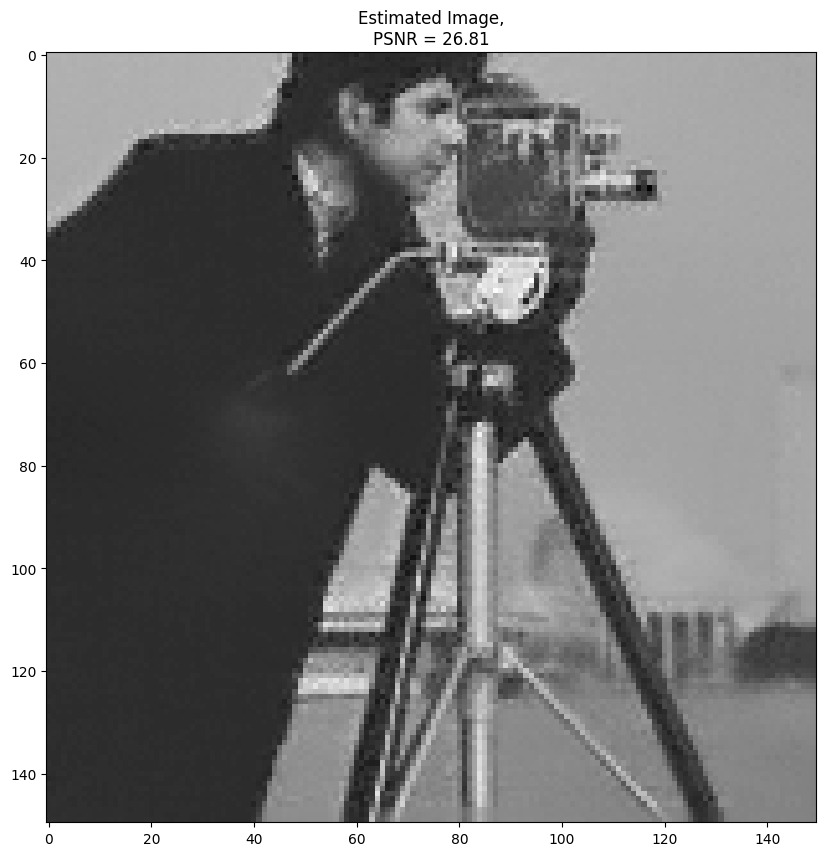

In [22]:
psnr_hat = lib.psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}');